# Queries

# SQL ingestion

```
WITH queries_with_events AS 
(
  select lower(json_extract_path_text(ir.request, 'query')) as query,
         count(distinct ir.retailer_token)::float as retailers_searching,
         count(distinct case when e.retailer_id is not null then ir.retailer_token end)::float as retailers_clicking,
         retailers_clicking / retailers_searching as conversion
  from kinesis.impression_requests ir
  join kinesis.product_impressions pi
  on pi.request_id = ir.request_id
  JOIN production.products p
  on pi.product_token = p.token
  JOIN production.brands b
  on p.brand_id = b.id
  join production.retailers r
  on r.token = ir.retailer_token
  left join kinesis.events e
  on e.retailer_id = r.id
       and e.created_at between ir.created_at_timestamp and ir.created_at_timestamp + interval '120 second'
       and ( (e.normalized_path = '/api/product/{PRODUCT}' and e.product_token = pi.product_token) )
  where ir.created_at_timestamp < '2019-02-11'
  and ir.path like '/api/search/query-products/from-inventory/false/%'
  -- where ir.created_at_timestamp > GETDATE() - interval '30 day'
  group by 1 
  -- having retailers_searching > 10 
  order by 4 desc
),
queries_brand_clicks AS 
(
  select lower(json_extract_path_text(ir.request, 'query')) as query,
         count(distinct ir.retailer_token)::float as retailers_searching,
         count(distinct case when e.retailer_id is not null then ir.retailer_token end)::float as retailers_clicking,
         retailers_clicking / retailers_searching as conversion
  from kinesis.impression_requests ir
  join kinesis.product_impressions pi
  on pi.request_id = ir.request_id
  JOIN production.products p
  on pi.product_token = p.token
  JOIN production.brands b
  on p.brand_id = b.id
  join production.retailers r
  on r.token = ir.retailer_token
  left join kinesis.events e
  on e.retailer_id = r.id
       and e.created_at between ir.created_at_timestamp and ir.created_at_timestamp + interval '120 second'
       and e.normalized_path = '/api/brand/{BRAND}/products' and e.brand_token = b.token 
  where ir.created_at_timestamp < '2019-02-11'
  and ir.path like '/api/search/query-products/from-inventory/false/%'
  -- where ir.created_at_timestamp > GETDATE() - interval '30 day'
  group by 1 
  -- having retailers_searching > 10 
  order by 4 desc
),

queries_with_clicks AS 
(
select lower(json_extract_path_text(ir.request, 'query')) as query,
       1.0*count(distinct ir.retailer_token) as retailers_searching,
       1.0*count(distinct case when c.request_id is not null then ir.retailer_token end) as retailers_clicking,
       1.0*retailers_clicking / retailers_searching as conversion
from kinesis.product_impressions pi
       join kinesis.impression_requests ir
            on ir.request_id = pi.request_id
       left join kinesis.clicks c
            on c.request_id = ir.request_id
where pi.path like '/api/search/query-products/from-inventory/false/%'
  and ir.created_at_timestamp >= '2019-02-11'
group by 1
-- HAVING retailers_searching > 10
order by conversion
)

SELECT qe.query,
       qe.retailers_searching as qe_retailers_searching,
       COALESCE(qc.retailers_searching, 0) as qc_retailers_searching,
       COALESCE(qb.retailers_searching, 0) as qb_retailers_searching,
       qe.retailers_clicking as qe_retailers_clicking,
       COALESCE(qc.retailers_clicking, 0) as qc_retailers_clicking,
       COALESCE(qb.retailers_clicking, 0) as qb_retailers_clicking,
       qe.retailers_searching + qc_retailers_searching + qb_retailers_searching as total_searches,
       qe.retailers_clicking + qc_retailers_clicking + qb_retailers_searching as total_clicks,
       total_clicks::float / total_searches as total_conversion
FROM queries_with_events qe
LEFT JOIN queries_with_clicks qc
  ON qc.query = qe.query
  LEFT JOIN queries_brand_clicks qb
    ON qc.query = qb.query
-- WHERE total_conversion < 0.3
ORDER BY 2 DESC
```

# Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# df = pd.read_csv('../datascience/search-suggestions/data/search_optimization.csv')
df = pd.read_csv('../datascience/search-suggestions/data/search_terms_Mar04_2019.csv')

In [3]:
df.shape

(35923, 10)

In [4]:
df_untouched = df.copy()

In [5]:
df['query'] = df['query'].str.strip()
df['query'] = df['query'].str.rstrip()
df['query'] = df['query'].str.lstrip()

In [6]:
df.loc[df['total_searches']<10, 'query'].tail()

35918    tie dye clothing
35919     beauty scholars
35920      lavender budle
35921              us map
35922       buffalo patch
Name: query, dtype: object

In [7]:
df.head(20)

,query,qe_retailers_searching,qc_retailers_searching,qb_retailers_searching,qe_retailers_clicking,qc_retailers_clicking,qb_retailers_clicking,total_searches,total_clicks,total_conversion
0,candles,634.0,415.0,634.0,326.0,210.0,365.0,1683.0,1170.0,0.695187
1,chocolate,406.0,111.0,406.0,246.0,66.0,290.0,923.0,718.0,0.777898
2,tea,356.0,231.0,356.0,170.0,132.0,194.0,943.0,658.0,0.697773
3,candle,327.0,171.0,327.0,172.0,91.0,196.0,825.0,590.0,0.715152
4,soap,298.0,166.0,298.0,166.0,100.0,192.0,762.0,564.0,0.740157
5,socks,266.0,130.0,266.0,89.0,61.0,153.0,662.0,416.0,0.628399
6,bath bombs,244.0,137.0,244.0,148.0,105.0,178.0,625.0,497.0,0.795200
7,valentine's day,239.0,1.0,239.0,113.0,0.0,131.0,479.0,352.0,0.734864
8,coffee,238.0,137.0,238.0,128.0,74.0,150.0,613.0,440.0,0.717781
9,cbd,234.0,153.0,234.0,135.0,107.0,149.0,621.0,476.0,0.766506


In [8]:
def count_words(sentence):
    return len([x for x in sentence.split()])

In [9]:
df['query'].apply(lambda x: count_words(x)).value_counts()

2     17862
1      8821
3      6637
4      1665
5       487
6       209
7       114
8        62
9        29
10       18
11       10
12        4
13        2
52        1
14        1
0         1
Name: query, dtype: int64

In [10]:
df.sort_values(by='total_searches', ascending=False)[['query', 'total_searches']].head(10)

,query,total_searches
0,candles,1683.0
2,tea,943.0
1,chocolate,923.0
3,candle,825.0
4,soap,762.0
5,socks,662.0
10,undefined,655.0
19,easter,639.0
6,bath bombs,625.0
9,cbd,621.0


In [11]:
df.loc[df['query'].str.contains("\'s"), ['total_searches', 'query']].sort_values(
    by='total_searches', ascending=False).head(20)

,total_searches,query
7,479.0,valentine's day
1030,55.0,mother's day
351,30.0,valentine's
2082,26.0,st. patrick's day
1420,25.0,men's
3325,17.0,men's grooming
4253,16.0,women's clothing
816,15.0,valentine's day cards
3339,9.0,father's day
10033,9.0,men's gifts


# Ask for at least 5 searches

In [12]:
df = df.loc[df['total_searches']>5, :]

In [13]:
df['query'].apply(lambda x: count_words(x)).value_counts()

1    2480
2    2352
3     329
4      26
5       3
0       1
Name: query, dtype: int64

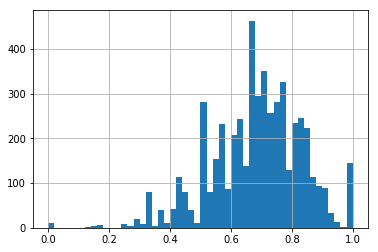

In [14]:
df.loc[df['total_searches']>5, 'total_conversion'].hist(bins=50)

## Drop queries with less than 40% conversion

In [15]:
df = df.loc[df['total_conversion']>0.40, :]

In [16]:
df.shape

(4978, 10)

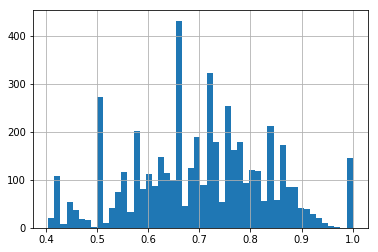

In [17]:
df.loc[df['total_searches']>5, 'total_conversion'].hist(bins=50)

In [18]:
df.loc[(df['total_searches']>5) &
       df['total_conversion'] < 0.3, 'query'].head(20)

Series([], Name: query, dtype: object)

In [19]:
df['query'].apply(lambda x: count_words(x)).value_counts()

1    2372
2    2262
3     315
4      25
5       3
0       1
Name: query, dtype: int64

### People use search to find individual products

In [20]:
df.loc[df['query'].apply(lambda x: count_words(x))>4, 'query']

2000    the bee and the fox
2132    go jump in the lake
2260     all up in the hair
Name: query, dtype: object

## Collapse hyphenated words

In [21]:
hyphen_words = df.loc[df['query'].str.contains(r'\w-\w'), 'query'].values.tolist()

In [22]:
print(hyphen_words)

['t-shirts', 't-shirt']


In [23]:
for w in hyphen_words:
    w_wo_hyphen = w.replace('-', ' ')
    w_wo_hyphen2 = w.replace('-', '')
    
    best_word = None
    max_searches = 0
    
#     print((df['query']==w).sum())
#     print((df['query']==w_wo_hyphen).sum())
#     prin˜t((df['query']==w_wo_hyphen2).sum())
    
    if df.loc[df['query']==w, 'total_searches'].values[0] >= df.loc[df['query']==w_wo_hyphen, 'total_searches'].values[0]:
        df.loc[df['query']==w_wo_hyphen, 'query'] = w
        max_searches = df.loc[df['query']==w, 'total_searches'].values
    else:
        best_word = w_wo_hyphen
        max_searches = df.loc[df['query']==w_wo_hyphen, 'total_searches'].values
        df.loc[df['query']==w, 'query'] = w_wo_hyphen
    
    if df.loc[df['query']==w_wo_hyphen2, 'total_searches'].values >= max_searches:
        df.loc[df['query']==best_word, 'query'] = w_wo_hyphen2
    else:
        df.loc[df['query']==w_wo_hyphen2, 'query'] = best_word

## Convert queries to use apostrophe when appropriate

In [24]:
apostrophe_words = df.loc[df['query'].str.contains("\'s"), 'query'].values.tolist()

In [25]:
apostrophe_words = [ [y for y in x.split() if "'s" in y ][0] for x in apostrophe_words]

In [26]:
short_apostrophe_words = []
for x in apostrophe_words:
    if x not in short_apostrophe_words:
        short_apostrophe_words.append(x)

In [27]:
short_apostrophe_words

["valentine's",
 "mother's",
 "men's",
 "patrick's",
 "children's",
 "father's",
 "women's",
 "aenon's",
 "oyster's"]

In [28]:
dict_to_change = {
    'mens': "men's", 
    'womens': "women's", 
    'valentines': "valentine's", 
    'mothers': "mother's", 
    'patricks': "patrick's",
    'st': "st."
}

In [29]:
# df['query'] = df['query'].str.replace("valentine's", "Valentine's")
# df['query'] = df['query'].str.replace("patrick's", "Patrick's")

In [30]:
df['needs_change'] = df['query'].apply(
    lambda x: any([y.lower() in dict_to_change.keys() for y in x.split()])
)

In [31]:
df.loc[df['needs_change']==1, 'query']

13                valentines
18            valentines day
188                     mens
405         valentines cards
414     valentines day cards
633              mothers day
652          valentines card
737          st patricks day
1081             st patricks
1130              st patrick
1173            mens jewelry
1376         womens clothing
1663     valentines day card
1715            womens shoes
1829           mens grooming
1892              mens socks
2121           mens clothing
2126        st patrick’s day
2611           mens bracelet
2914                  womens
2955             womens tops
3170            mens wallets
3211             mens wallet
3457          womens apparel
4054        st. patricks day
4716              mens shirt
4909               mens ties
5179        st patrick's day
5280       mothers day gifts
5381          womens clothes
5399            st patrick’s
5479       mothers day cards
6943               mens hats
Name: query, dtype: object

In [32]:
for k,v in dict_to_change.items():
    df.loc[df['needs_change']==1, 'query'] = df.loc[df['needs_change']==1, 'query'].apply(
        lambda x: x.replace(k, v) )

### Now colapse them together

In [33]:
df = df.groupby('query').sum().reset_index().sort_values('total_searches', ascending=False)
df['total_conversion'] = df['total_clicks'] / df['total_searches']

In [34]:
#df['query'].apply(lambda x: x.replace("'s", '') in apostrophe_words)

In [35]:
df.loc[ df['query'].apply(lambda x: x.replace("'s", '') in apostrophe_words), 'query']

Series([], Name: query, dtype: object)

In [36]:
df.loc[df['query'].str.contains("\'s"), ['total_searches', 'query']].sort_values(
    by='total_searches', ascending=False).head(20)

,total_searches,query
4586,848.0,valentine's day
4583,445.0,valentine's
2752,141.0,men's
2912,140.0,mother's day
4067,81.0,st. patrick's day
4588,42.0,valentine's day cards
4833,41.0,women's clothing
2756,39.0,men's grooming
4066,35.0,st. patrick's
4585,34.0,valentine's cards


In [37]:
df['query'].apply(lambda x: count_words(x)).value_counts()

1    2367
2    2253
3     309
4      25
5       3
0       1
Name: query, dtype: int64

# Coalesce singular and plural by whichever has most searches

In [38]:
words_with_s = df.loc[(df['query'].str.rstrip('s').isin(df['query']) 
                       & (df['query'].str[-1]=='s')), 'query'].values.tolist()

In [39]:
'bras' in words_with_s

True

In [40]:
words_with_s[:5]

['candles', 'socks', 'bath bombs', 'mugs', 'cards']

In [41]:
df.loc[df['query']=='socks', 'total_searches'].values[0]

662.0

In [42]:
queries = df['query'].unique().tolist()
for w in words_with_s:
    if w[-2:]=='ss':
        continue
    if w[:-1] in df['query'].unique().tolist():
        if df.loc[df['query']==w, 'total_searches'].values[0] >= df.loc[df['query']==w[:-1], 'total_searches'].values[0]:
            print('Replacing {} with {}'.format(w[:-1], w))
            df.loc[df['query']==w[:-1], 'query'] = w
        else:
            print('Replacing {} with {}'.format(w, w[:-1]))
            df.loc[df['query']==w, 'query'] = w[:-1]
    

Replacing candle with candles
Replacing sock with socks
Replacing bath bomb with bath bombs
Replacing mug with mugs
Replacing card with cards
Replacing pillow with pillows
Replacing crystal with crystals
Replacing book with books
Replacing ceramic with ceramics
Replacing tea towel with tea towels
Replacing essential oil with essential oils
Replacing shoe with shoes
Replacing hat with hats
Replacing journals with journal
Replacing handbag with handbags
Replacing plant with plants
Replacing baskets with basket
Replacing planters with planter
Replacing tshirt with tshirts
Replacing greeting card with greeting cards
Replacing earring with earrings
Replacing bag with bags
Replacing pen with pens
Replacing sticker with stickers
Replacing coffee mug with coffee mugs
Replacing kid with kids
Replacing tea drop with tea drops
Replacing purses with purse
Replacing sign with signs
Replacing bath salt with bath salts
Replacing coaster with coasters
Replacing towel with towels
Replacing seed with se

Replacing wax warmers with wax warmer
Replacing shopping bag with shopping bags
Replacing bandanas with bandana
Replacing produce bags with produce bag
Replacing bangle with bangles
Replacing leather journals with leather journal
Replacing car coaster with car coasters
Replacing sport with sports
Replacing recipe card with recipe cards
Replacing letter board with letter boards
Replacing throw pillows with throw pillow
Replacing sugar scrubs with sugar scrub
Replacing candels with candel
Replacing taper candles with taper candle
Replacing linen sheet with linen sheets
Replacing candle warmer with candle warmers
Replacing leather purses with leather purse
Replacing pillar candles with pillar candle
Replacing lights with light
Replacing markers with marker
Replacing salt lamps with salt lamp
Replacing watch band with watch bands
Replacing tank top with tank tops
Replacing hair pins with hair pin
Replacing diy kit with diy kits
Replacing tassels with tassel
Replacing wine candles with wine

Replacing whales with whale
Replacing faux plants with faux plant
Replacing jewelry holders with jewelry holder
Replacing neck wraps with neck wrap
Replacing snack bags with snack bag
Replacing makeup erasers with makeup eraser
Replacing leather coasters with leather coaster
Replacing lambs with lamb
Replacing mixing bowls with mixing bowl
Replacing lemons with lemon
Replacing gold ring with gold rings
Replacing platters with platter
Replacing paper bags with paper bag
Replacing pitchers with pitcher
Replacing plant hangers with plant hanger
Replacing milestone blankets with milestone blanket
Replacing mixers with mixer
Replacing wish bracelets with wish bracelet
Replacing art kits with art kit
Replacing wine stoppers with wine stopper
Replacing onsies with onsie
Replacing baby teethers with baby teether
Replacing wrap bracelets with wrap bracelet
Replacing pool floats with pool float
Replacing wristlets with wristlet
Replacing anklets with anklet
Replacing hangers with hanger
Replacin

In [43]:
df = df.groupby('query').sum().reset_index().sort_values('total_searches', ascending=False)
df['total_conversion'] = df['total_clicks'] / df['total_searches']

In [44]:
df['n_words'] = df['query'].apply(lambda x: count_words(x))

In [45]:
df.loc[df['n_words']==2, 'query'].head()

285          bath bombs
4051    valentine's day
3810         tea towels
1290     essential oils
2230           lip balm
Name: query, dtype: object

In [46]:
df.head()

,query,qe_retailers_searching,qc_retailers_searching,qb_retailers_searching,qe_retailers_clicking,qc_retailers_clicking,qb_retailers_clicking,total_searches,total_clicks,total_conversion,needs_change,n_words
680,candles,961.0,586.0,961.0,498.0,301.0,561.0,2508.0,1760.0,0.701754,0.0,1
816,chocolate,490.0,122.0,490.0,310.0,71.0,355.0,1102.0,871.0,0.790381,0.0,1
285,bath bombs,407.0,212.0,407.0,246.0,152.0,298.0,1026.0,805.0,0.784600,0.0,2
3790,tea,370.0,239.0,370.0,173.0,135.0,201.0,979.0,678.0,0.692543,0.0,1
3532,soap,369.0,187.0,369.0,209.0,115.0,242.0,925.0,693.0,0.749189,0.0,1


In [47]:
"women's" in df['query'].values

True

## For queries with more than 1 word, add apostrophe when it should have it

In [48]:
add_apostrophe = ['women', 'men', 'kid', 'patrick']

In [49]:
df['query'].str.split()[0]

[]

In [50]:
df.loc[df['query'].str.contains('women'), 'query'].value_counts()

women's apparel      1
women's tops         1
women’s hats         1
women's clothing     1
women accessories    1
women's shoes        1
women's clothes      1
women's              1
women clothing       1
women                1
women’s shoes        1
women shoes          1
women’s clothing     1
Name: query, dtype: int64

In [51]:
df.loc[(df['query'].str.contains('women')) & (df['n_words']>1), 'query'].str.split()

4275     [women's, clothing]
4276        [women's, shoes]
4270       [women, clothing]
4277         [women's, tops]
4273      [women's, apparel]
4280        [women’s, shoes]
4278     [women’s, clothing]
4271          [women, shoes]
4269    [women, accessories]
4279         [women’s, hats]
4274      [women's, clothes]
Name: query, dtype: object

In [52]:
df.loc[(df['n_words']>1) & any([df['query'].str.split()[0] == w for w in add_apostrophe]), 'query']

Series([], Name: query, dtype: object)

In [53]:
df.loc[df['n_words']>1, 'query'] = df.loc[df['n_words']>1, 'query'].apply(
    lambda x: (x.split()[0] + "'s ")+' '.join(x.split()[1:]) if any([x.split()[0]==w for w in add_apostrophe])
    else x
)

In [54]:
df = df.groupby('query').sum().reset_index().sort_values('total_searches', ascending=False)
df['total_conversion'] = df['total_clicks'] / df['total_searches']

In [55]:
df.loc[df['query'].str.contains('women'), 'query'].value_counts()

women's apparel        1
women's clothes        1
women's                1
women’s hats           1
women's clothing       1
women                  1
women's shoes          1
women's tops           1
women’s clothing       1
women’s shoes          1
women's accessories    1
Name: query, dtype: int64

In [56]:
'women clothing' in df['query'].values

False

## Check apostrophe terms again

In [57]:
df.loc[df['query'].str.contains("\'s"), ['total_searches', 'query']].sort_values(
    by='total_searches', ascending=False).head(20)

,total_searches,query
4051,848.0,valentine's day
4049,445.0,valentine's
2441,141.0,men's
2589,140.0,mother's day
3614,81.0,st. patrick's day
4052,58.0,valentine's day cards
4273,56.0,women's clothing
4050,52.0,valentine's cards
2445,39.0,men's grooming
3613,35.0,st. patrick's


(0, 100)

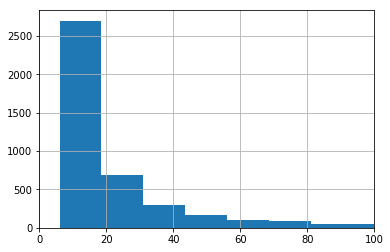

In [58]:
df['total_searches'].hist(bins=200)
plt.xlim(0, 100)

## Drop rows that are not in the dictionary

In [59]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import brown

nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/pedrosalesdebruin/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [60]:
'keychain' in brown.words()

False

In [61]:
print(wn.synsets('candel'))

[]


In [62]:
print(wn.synsets('answered'))

[Synset('answer.v.01'), Synset('answer.v.02'), Synset('answer.v.03'), Synset('answer.v.04'), Synset('answer.v.05'), Synset('answer.v.06'), Synset('suffice.v.01'), Synset('answer.v.08'), Synset('answer.v.09'), Synset('answer.v.10')]


In [63]:
print(wn.synsets('asiafhaosifh'))

[]


In [64]:
df.loc[df['n_words']==1, 'query'].apply(lambda x: len(wn.synsets(x))>0).sum()

1661

In [65]:
df.loc[df['n_words']==1].shape

(2087, 12)

In [66]:
df['word_in_dictionary'] = df.loc[df['n_words']==1, 'query'].apply(lambda x: len(wn.synsets(x))>0 )

In [67]:
df.loc[df['n_words']>1, 'word_in_dictionary'] = 1

In [68]:
df.loc[df['word_in_dictionary']==0, ['total_searches', 'query']].sort_values(
    'total_searches', ascending=False).head(30)

,total_searches,query
739,621.0,cbd
4049,445.0,valentine's
3979,426.0,tshirts
3598,291.0,spongelle
494,217.0,boho
2034,204.0,keychain
3324,154.0,scrunchie
1396,151.0,finchberry
3945,150.0,transpac
3828,139.0,teether


In [69]:
df.shape

(4382, 13)

In [70]:
df = df.loc[(df['word_in_dictionary']==1), :]

In [71]:
df.shape

(3955, 13)

In [72]:
df.loc[ df['query'].str.contains('\.'), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches
3614,st. patrick's day,81.0
2315,m. bueno,44.0
3613,st. patrick's,35.0
3616,st. patrick’s day,30.0
3612,st. patrick,27.0
14,a.n other,12.0
3617,st.. patrick's day,10.0
3615,st. patrick’s,7.0
2332,made market co.,7.0
2821,p.f. candle,7.0


In [73]:
df.loc[ df['query'].str.contains('\&'), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches
813,chloe & lex,22.0
1009,crafts & love,17.0
1459,fr & co,10.0
4101,w & p,10.0
2007,june & december,9.0
4257,wit & delight,8.0
1453,foster & rye,7.0
2598,mr & mrs,7.0
248,bangle & babe,6.0
3533,soap & paper factory,6.0


In [74]:
df.loc[ df['query'].str.contains('\^'), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches


In [75]:
df.loc[ df['query'].str.contains('\$'), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches


In [76]:
df.loc[ df['query'].str.contains('\%'), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches


In [77]:
df.loc[ df['query'].str.contains("\""), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches


In [78]:
df.loc[ df['query'].str.contains("\("), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches


In [79]:
df.loc[ df['query'].str.contains("\""), ['query', 'total_searches'] ].sort_values('total_searches', ascending=False)

,query,total_searches


# Words now missing from original list sorted by total searches

In [80]:
df_untouched.loc[(~df_untouched['query'].str.strip().isin(df['query']))
                 & ((df_untouched['query'].str.strip()+'s').isin(df['query']))
                 & (df_untouched['total_searches']>50)
                 , ['query', 'total_searches', 'total_conversion']]

,query,total_searches,total_conversion
3,candle,825.0,0.715152
22,bath bomb,401.0,0.768080
25,mug,371.0,0.719677
43,pillow,323.0,0.625387
59,tea towel,235.0,0.685106
82,crystal,217.0,0.691244
94,ceramic,192.0,0.692708
95,plant,198.0,0.681818
98,hat,191.0,0.549738
101,essential oil,186.0,0.768817


In [81]:
'tea towels' in df['query'].values

True

In [82]:
df_untouched.loc[~(df_untouched['query'].str.strip().isin(df['query']))
                 & ((df_untouched['query'].str.rstrip('s')).isin(df['query']))
                 & (df_untouched['total_searches']>50)
                 , ['query', 'total_searches', 'total_conversion']]

,query,total_searches,total_conversion
13,valentines,415.0,0.754217
39,journals,297.0,0.787879
54,planters,252.0,0.797619
56,baskets,260.0,0.707692
79,purses,212.0,0.693396
81,chocolates,179.0,0.854749
100,blankets,181.0,0.668508
112,soaps,155.0,0.793548
119,notebooks,148.0,0.831081
130,hearts,120.0,0.816667


In [83]:
df_untouched.loc[~( (df_untouched['query'].str.strip().isin(df['query']))
                  | ((df_untouched['query'].str.strip()+'s').isin(df['query'])) 
                  | ((df_untouched['query'].str.rstrip('s')).isin(df['query'])) 
                  )
                 & (df_untouched['total_searches']>10)
                 , ['query', 'total_searches', 'total_conversion']].head(20)

,query,total_searches,total_conversion
9,cbd,621.0,0.766506
10,undefined,655.0,0.381679
18,valentines day,369.0,0.753388
49,spongelle,291.0,0.766323
74,boho,217.0,0.764977
121,finchberry,151.0,0.761589
137,keychain,141.0,0.737589
149,transpac,150.0,0.746667
188,mens,116.0,0.741379
218,druzy,104.0,0.730769


In [84]:
'baby clothes' in df['query'].values

True

In [85]:
df_untouched['query'].str.contains('womens').sum()

74

In [86]:
df['query'].str.contains('womens').sum()

0

In [87]:
df['query'].str.contains("women's").sum()

6

In [88]:
df.loc[df['query'].str.contains('women'), 'query']

4273       women's clothing
4268                  women
4274          women's shoes
4275           women's tops
4271        women's apparel
4278          women’s shoes
4276       women’s clothing
4277           women’s hats
4272        women's clothes
4270    women's accessories
Name: query, dtype: object

In [89]:
'cutting board' in df['query'].values

True

In [90]:
df.loc[df['query'].str.contains('cutting'), ['query', 'total_searches']]

,query,total_searches
1063,cutting board,209.0
4289,wood cutting board,8.0


In [91]:
df['query'].shape

(3955,)

In [92]:
df.loc[df['query'].str.contains("\'s"), ['total_searches', 'query']].sort_values(
    by='total_searches', ascending=False).head(20)

,total_searches,query
4051,848.0,valentine's day
2441,141.0,men's
2589,140.0,mother's day
3614,81.0,st. patrick's day
4052,58.0,valentine's day cards
4273,56.0,women's clothing
4050,52.0,valentine's cards
2445,39.0,men's grooming
3613,35.0,st. patrick's
2447,32.0,men's jewelry


## Write a final list

In [93]:
'hoodie' in df['query'].values

False

In [94]:
"men's jewelry" in df['query'].values

True

In [95]:
"valentine's day cards" in df['query'].values

True

In [96]:
df['score1'] = df['total_searches']
df['score2'] = df['total_searches'] * df['total_conversion']
df['score3'] = df['total_searches'] * (1. + 0.5*df['total_conversion'])
df['score4'] = df['total_searches'] * (1. + df['total_conversion'])

In [97]:
df[['query', 'total_searches', 'score1', 'score2', 'score3', 'score4']].head()

,query,total_searches,score1,score2,score3,score4
680,candles,2508.0,2508.0,1760.0,3388.0,4268.0
816,chocolate,1102.0,1102.0,871.0,1537.5,1973.0
285,bath bombs,1026.0,1026.0,805.0,1428.5,1831.0
3790,tea,979.0,979.0,678.0,1318.0,1657.0
3532,soap,925.0,925.0,693.0,1271.5,1618.0


In [98]:
df.shape

(3955, 17)

In [99]:
df[['query', 'total_searches']].head(100)

,query,total_searches
680,candles,2508.0
816,chocolate,1102.0
285,bath bombs,1026.0
3790,tea,979.0
3532,soap,925.0
2608,mugs,882.0
4051,valentine's day,848.0
2976,pillows,752.0
3551,socks,695.0
2000,journal,651.0


In [100]:
df_untouched.loc[df_untouched['query']=='candle', 'total_searches']

3    825.0
Name: total_searches, dtype: float64

In [101]:
df_untouched.loc[df_untouched['query']=='candles', 'total_searches']

0    1683.0
Name: total_searches, dtype: float64

In [102]:
df[['query', 'total_searches']].sort_values('total_searches', ascending=False).head(100).to_csv(
    'top100_suggestions', index=False)

In [103]:
'candle' in df['query'].values

False

In [104]:
'candle sticks' in df['query'].values

True

In [105]:
'candle stick' in df['query'].values

False

In [106]:
df.shape

(3955, 17)

In [107]:
df_untouched.loc[df_untouched['query'].isin(['t-shirt', 't-shirts', 'tshirts', 'tshirt']), ['query', 'total_searches']]

,query,total_searches
243,tshirts,111.0
312,tshirt,74.0
645,t-shirts,46.0
911,t-shirt,36.0


In [108]:
't-shirt' in df['query'].values

False

In [109]:
'tshirts' in df['query'].values

False

In [110]:
't-shirts' in df['query'].values

False

# Search for profanity

In [111]:
from profanityfilter import ProfanityFilter
pf = ProfanityFilter()

In [112]:
for q in df['query'].tolist():
    if pf.has_bad_word(q):
        print('WARNING: is {} a bad word?'.format(q))

In [113]:
pf.has_bad_word('balloon')

False

In [114]:
'candel' in df['query'].tolist()

False

# Blacklist some suggestions

In [115]:
blacklist = ['penis', 'vagina', 'poop',  "valentine", 'tits', 
             'boobs', 'sex', 'bitch', 'fuck', 'dick', 'sex toys', 'shit',
             'cbd', 'cannabis', 'hemp', 'marijuana'
            ]

In [116]:
for x in blacklist:
    df = df.loc[~df['query'].str.contains(x), :]

In [117]:
df.shape

(3924, 17)

In [118]:
df[['query', 'total_searches', 'score1', 'score2', 'score3', 'score4']].to_csv(
    '../datascience/data/search_autocomplete.csv', index=False) 

In [119]:
df['query'] = df['query'].str.strip()

In [120]:
df['score_t'] = df['score1'].apply(str).str.strip()

In [121]:
df['score1'].head().iloc[0]

2508.0

In [122]:
df['query'].head().iloc[0]

'candles'

In [123]:
df[['query', 'score_t']].to_csv('../datascience/search-suggestions/data/search_autocomplete.tsv'
    , sep='\t', index=False, encoding='utf-8', header=False)

In [124]:
df[['query', 'score_t']].to_csv('../datascience/data/search_autocomplete.csv', index=False)